#Import Lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/VGU AI/Softmax Regression

/content/drive/MyDrive/Colab Notebooks/VGU AI/Softmax Regression


In [4]:
df=pd.read_csv(
    'Twitter_Data.csv',
)

In [5]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [6]:
#xoa NaN data
df=df.dropna()

In [7]:
#preprocess
def text_normalize ( text ):
	#Lowercasing
	text = text.lower()

	# Retweet old acronym "RT" removal
	text = re.sub(r'^rt [\s]+ ', '', text )

	# Hyperlinks removal
	text = re.sub(r'https ?:\/\/.*[\ r\n]* ', '', text )

	# Punctuation removal
	text = re.sub(r'[^\w\s]', '', text )

	# Remove stopwords
	stop_words = set( stopwords.words('english') )
	words = text.split()
	words = [ word for word in words if word not in stop_words ]
	text = ' '.join( words )

	# Stemming
	stemmer = SnowballStemmer('english')
	words = text.split()
	words = [ stemmer.stem(word) for word in words ]
	text = ' '.join( words )
	return text

In [8]:
#init tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()


In [9]:
#add bias into X
tmp=np.ones((X.shape[0],1))
X=np.concatenate((tmp,X),axis=1)

In [10]:
#one-hot encode y
n_classes=df['category'].nunique()
n_samples=df['category'].size

y=df['category'].to_numpy()+1
y=y.astype(np.uint8)
y_encoded=np.zeros((n_samples,n_classes))
y_encoded[np.arange(n_samples),y]= 1

In [11]:
val_size=0.2
test_size=0.125
random_state=2
shuffle=True
X_train,X_val,y_train,y_val=train_test_split(
    X,y_encoded,
    test_size=test_size,
    random_state=random_state,
    shuffle=shuffle
)
X_train,X_test,y_train,y_test=train_test_split(
    X_train,y_train,
    test_size=val_size,
    shuffle=shuffle
)

# Craft model

##Define modules

In [ ]:
def softmax(z):
    exp_z=np.exp(z)
    return exp_z/(exp_z).sum(axis=1).reshape(-1,1)

In [ ]:
def predict(X,W):
    return softmax(np.dot(X,W))

In [ ]:
def compute_loss(y_hat,y):
    return (-1/y.size)*np.sum(y*np.log(y_hat))

In [ ]:
def compute_accuracy(y_hat,y):
    return (np.argmax(y_hat,axis=1)==np.argmax(y,axis=1)).mean()

In [ ]:
def compute_gradient(X,y_hat,y):
    return np.dot(X.T,(y_hat-y))/y.size

In [ ]:
def update_W(W,gradient,lr,lamb):
    return W-(lr*gradient+lamb*W)

##Model

In [ ]:
#init
lr=0.1
epochs=200
batch_size=8192
lamb=0.000001

np.random.seed(random_state)
n_features=X_train.shape[1]
n_classes=y_train.shape[1]
W=np.random.uniform(size=(n_features,n_classes))

In [ ]:
train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]
for epoch in range(epochs):
    train_batch_losses=[]
    train_batch_accs=[]
    val_batch_losses=[]
    val_batch_accs=[]
    for i in range(0,X_train.shape[0],batch_size):
        X_batch=X_train[i:i+batch_size]
        y_batch=y_train[i:i+batch_size]

        #train
        y_hat=predict(X_batch,W)
        train_batch_losses.append(compute_loss(y_hat,y_batch))
        train_batch_accs.append(compute_accuracy(y_hat,y_batch))

        #validate
        y_hat_val=predict(X_val,W)
        val_batch_losses.append(compute_loss(y_hat_val,y_val))
        val_batch_accs.append(compute_accuracy(y_hat_val,y_val))

        #gradient descent
        gradient=compute_gradient(X_batch,y_hat,y_batch)
        W=update_W(W,gradient,lr,lamb)

    train_losses.append(np.array(train_batch_losses).mean())
    train_accs.append(np.array(train_batch_accs).mean())
    val_losses.append(np.array(val_batch_losses).mean())
    val_accs.append(np.array(val_batch_accs).mean())
    if (epoch+1)%20==0:
        print(f'EPOCH {epoch+1}:\tTraning Loss: {train_losses[-1]:.3f}\tValidation Loss: {val_losses[-1]:.3f}')

EPOCH 20:	Traning Loss: 0.358	Validation Loss: 0.358
EPOCH 40:	Traning Loss: 0.357	Validation Loss: 0.356
EPOCH 60:	Traning Loss: 0.355	Validation Loss: 0.355
EPOCH 80:	Traning Loss: 0.354	Validation Loss: 0.354
EPOCH 100:	Traning Loss: 0.353	Validation Loss: 0.352
EPOCH 120:	Traning Loss: 0.351	Validation Loss: 0.351
EPOCH 140:	Traning Loss: 0.350	Validation Loss: 0.350
EPOCH 160:	Traning Loss: 0.349	Validation Loss: 0.349
EPOCH 180:	Traning Loss: 0.348	Validation Loss: 0.347
EPOCH 200:	Traning Loss: 0.346	Validation Loss: 0.346


##Evaluation

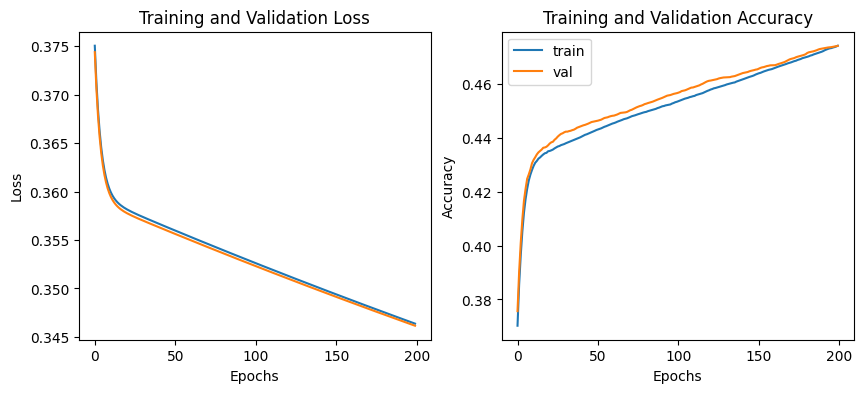

In [ ]:
import matplotlib.pyplot as plt

fig,axs=plt.subplots(1,2,figsize=(10,4))

axs[0].plot(train_losses,label='train')
axs[0].plot(val_losses,label='val')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

axs[1].plot(train_accs,label='train')
axs[1].plot(val_accs,label='val')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

plt.legend()
plt.show()

#TF model

In [12]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Dropout,Input

In [13]:
X_train.shape[1]

2001

In [14]:
y_train.shape

(114077, 3)

In [16]:
input=Input(shape=(2001))
x=Dense(512,activation='relu')(input)
x=Dropout(0.5)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.5)(x)
output=Dense(3)(x)
model=Model(inputs=input,outputs=output)

In [17]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=tf.keras.metrics.CategoricalAccuracy()
)

In [18]:
earlyStopping=tf.keras.callbacks.EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

In [19]:
history=model.fit(
    X_train,y_train,
    validation_data=(X_val,y_val),
    batch_size=512,
    epochs=200,
    callbacks=[earlyStopping]
)

Epoch 1/200
223/223 [==============================] - 7s 10ms/step - loss: 1.0518 - categorical_accuracy: 0.4422 - val_loss: 0.9903 - val_categorical_accuracy: 0.4878
Epoch 2/200
223/223 [==============================] - 1s 6ms/step - loss: 0.8410 - categorical_accuracy: 0.6223 - val_loss: 0.5767 - val_categorical_accuracy: 0.7908
Epoch 3/200
223/223 [==============================] - 2s 7ms/step - loss: 0.5656 - categorical_accuracy: 0.7878 - val_loss: 0.4199 - val_categorical_accuracy: 0.8669
Epoch 4/200
223/223 [==============================] - 1s 6ms/step - loss: 0.4575 - categorical_accuracy: 0.8467 - val_loss: 0.3802 - val_categorical_accuracy: 0.8839
Epoch 5/200
223/223 [==============================] - 1s 6ms/step - loss: 0.4115 - categorical_accuracy: 0.8675 - val_loss: 0.3706 - val_categorical_accuracy: 0.8886
Epoch 6/200
223/223 [==============================] - 1s 6ms/step - loss: 0.3875 - categorical_accuracy: 0.8778 - val_loss: 0.3634 - val_categorical_accuracy: 0.89

In [20]:
history_df = pd.DataFrame(history.history)

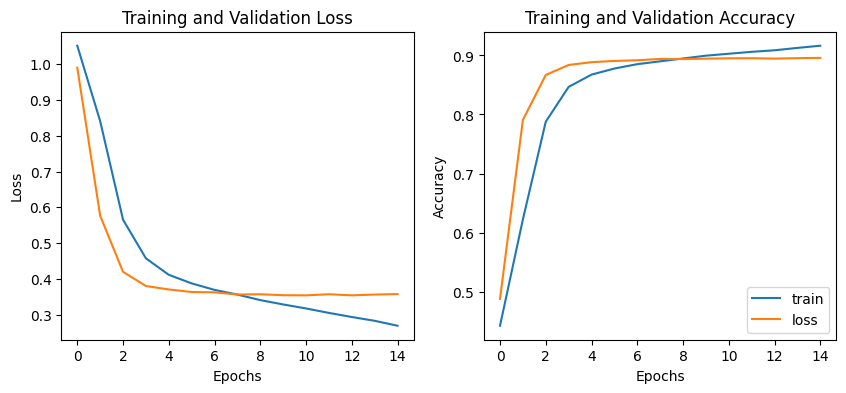

In [21]:
fig,axs=plt.subplots(1,2,figsize=(10,4))

axs[0].plot(history_df.loc[:, ['loss']],label='train')
axs[0].plot(history_df.loc[:, ['val_loss']],label='val')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')

axs[1].plot(history_df.loc[:, ['categorical_accuracy']],label='train')
axs[1].plot(history_df.loc[:, ['val_categorical_accuracy']],label='loss')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')

plt.legend()
plt.show()